In [1]:
import numpy as np
import torch 
from torch import nn
from torch.nn import functional as F

from typing import List, Callable, Union, Any, TypeVar, Tuple
Tensor = TypeVar('torch.tensor')

import torch.optim as optim


# Data preprocessing utils : 
from acdc_dataset import ACDC_Dataset, One_hot_Transform, load_dataset
from torchvision.transforms import Compose
from torchvision import transforms

from torch.utils.data import DataLoader


# Visuals utils
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


# my defined model
from vqVAE import VQVAE

import warnings
warnings.filterwarnings("ignore")

/home/ids/ihamdaoui-21/anaconda3/envs/torch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def reconstruct2(batch, model):
    z_e = model.encode(batch.float().to(device))[0]
    z_q, _ , _= model.vq_layer(z_e)
    img_hat = model.decode(z_q)
    return img_hat

def reconstruct(batch, model):
    output, _, _, _ = model(batch.float())
    return output

def save_model(model, epoch, ):
    checkpoint_path = os.path.join( os.getcwd() , model_name )
    torch.save({'epoch' : epoch,
                'model_state_dict': model.state_dict()}, checkpoint_path)

def visualize_batch(batch, title):
    batch_size = batch.shape[0]
    samples = 8


    fig, axes = plt.subplots(samples, 4, figsize=(10, 20))  # Adjust figsize to accommodate more rows
    fig.suptitle(title, fontsize=16)

    for ax in axes.flat:
        ax.set_axis_off()

    for i in range(samples):

        img = batch[i]
        axes[i,0].imshow(img[0,:,:], cmap = 'gray')
        axes[i,1].imshow(img[1,:,:], cmap = 'gray')
        axes[i,2].imshow(img[2,:,:], cmap = 'gray')
        axes[i,3].imshow(img[3,:,:], cmap = 'gray')
        # axes[i].axis('off')

    
    # plt.tight_layout()
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

In [ ]:
###########################        Training ....      #################################
def dice_loss(preds, targets, smooth=1e-6):
    """
    Calculate Dice Loss across the 4 segmentation channels.
    :param preds: Predicted output tensor of shape [batch_size, 4, height, width]
    :param targets: Ground truth one-hot tensor of shape [batch_size, 4, height, width]
    :param smooth: A small value to avoid division by zero
    :return: Dice Loss (scalar)
    """
    # Ensure that the prediction is in probability space (use softmax if logits are provided)
    # Uncomment the following line if your model does not already output probabilities
    preds = F.softmax(preds, dim=1)  # Apply softmax over channel dimension (4 channels)

    # Flatten predictions and targets to calculate Dice coefficient for each channel
    preds_flat = preds.contiguous().view(preds.shape[0], preds.shape[1], -1)  # [batch_size, 4, height*width]
    targets_flat = targets.contiguous().view(targets.shape[0], targets.shape[1], -1)  # [batch_size, 4, height*width]

    intersection = (preds_flat * targets_flat).sum(dim=2)  # Summing over height and width dimensions
    union = preds_flat.sum(dim=2) + targets_flat.sum(dim=2)  # Sum of both sets

    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)  # Dice coefficient per channel
    dice_loss = 1 - dice_coeff.mean()  # Average over the batch and channels

    return dice_loss

import torch
import torch.nn.functional as F

def dice_loss_hard(preds, targets, smooth=1e-6):
    """
    Calculate Dice Loss across the 4 segmentation channels using binary masks.
    :param preds: Predicted output tensor of shape [batch_size, 4, height, width] (logits or soft predictions)
    :param targets: Ground truth one-hot tensor of shape [batch_size, 4, height, width]
    :param smooth: A small value to avoid division by zero
    :return: Dice Loss (scalar)
    """
    # Apply softmax over channel dimension (4 channels) to convert logits to probabilities
    preds = F.softmax(preds, dim=1)

    # Convert probabilities to binary one-hot predictions by using argmax and one-hot encoding
    preds_bin = torch.argmax(preds, dim=1)  # Shape: [batch_size, height, width] (class index for each pixel)
    preds_onehot = F.one_hot(preds_bin, num_classes=4).permute(0, 3, 1, 2).float()  # Shape: [batch_size, 4, height, width]

    # Flatten predictions and targets for dice coefficient calculation
    preds_flat = preds_onehot.contiguous().view(preds_onehot.shape[0], preds_onehot.shape[1], -1)  # [batch_size, 4, height*width]
    targets_flat = targets.contiguous().view(targets.shape[0], targets.shape[1], -1)  # [batch_size, 4, height*width]

    # Calculate intersection and union
    intersection = (preds_flat * targets_flat).sum(dim=2)  # Summing over height and width dimensions
    union = preds_flat.sum(dim=2) + targets_flat.sum(dim=2)  # Sum of both sets

    # Calculate Dice coefficient and Dice loss
    dice_coeff = (2.0 * intersection + smooth) / (union + smooth)  # Dice coefficient per channel
    dice_loss = 1 - dice_coeff.mean()  # Average over the batch and channels

    return dice_loss



def evaluate_model(model, val_loader):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch.float().to(device)
           
            outputs, _, _, _ = model(inputs)
            outputs_binary = F.softmax(outputs, dim=1)
            
            # Loss and backward
            loss = dice_loss(inputs, outputs)
            
            val_loss += loss.item()
    
    avg_val_loss = val_loss / len(val_loader.dataset)
    return avg_val_loss




## Preparing Dataset 

In [3]:
L = 128 # image size L=W
BATCH_SIZE = 16

In [4]:
dataset_path = "/home/ids/ihamdaoui-21/ACDC/database"

train_set_path = os.path.join(dataset_path, "training")
test_set_path  = os.path.join(dataset_path, "testing")


In [5]:
train_dataset = load_dataset(train_set_path)
test_dataset  = load_dataset(test_set_path)


input_transforms = Compose([
    transforms.Resize(size=(L,L), interpolation=transforms.InterpolationMode.NEAREST),
    One_hot_Transform(num_classes=4)
    ])


TrainDataset = ACDC_Dataset(data = train_dataset, transforms= input_transforms) 
TestDataset  = ACDC_Dataset(data = test_dataset, transforms= input_transforms)

TrainLoader  = DataLoader(TrainDataset, batch_size = BATCH_SIZE, shuffle = True)
TestLoader   = DataLoader(TestDataset , batch_size = BATCH_SIZE, shuffle = True)

NiftiImageIO (0x9ed90e0): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x9ed90e0): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x9f8cb30): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame16_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x9f8cb30): /home/ids/ihamdaoui-21/ACDC/database/training/patient042/patient042_frame16_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x9efb0c0): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0x9efb0c0): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame01_gt.nii.gz has unexpected scales in sform

NiftiImageIO (0xa26fcc0): /home/ids/ihamdaoui-21/ACDC/database/training/patient035/patient035_frame11_gt.nii.gz has unexpected scales in

## Prepairing the model

In [ ]:
K =  512 # num_embeddings
D =  64 # embedding_dim
in_channels = 4 

In [7]:
ACDC_VQVAE = VQVAE(in_channels, D, K)

input = torch.rand(16, 4, 128, 128)

In [8]:
y = ACDC_VQVAE(input)
z_e = ACDC_VQVAE.encode(input)[0]
z_q, _ , _= ACDC_VQVAE.vq_layer(z_e)
codeBook = ACDC_VQVAE.vq_layer.embedding

## Training the Model

In [9]:
# detect gpu ?

print(torch.cuda.is_available())

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda:0


In [10]:
### Learning parameters

model = ACDC_VQVAE.to(device)

lr = 5e-4
epochs = 200
optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)

model_name = 'saved_models/vqvae_101_bestmodel.pth'


In [11]:
# visualisation batch, to track th eperformance of the model
vis_batch = next(iter(TestLoader)).to(device)

In [ ]:

model.train()
train_loss_values = []
codebook_loss_values = []

#track the evolution of reconstruction
recons_evolution = []

val_loss_values = []
best_val_loss = float('inf')

for epoch in range(epochs):

    train_loss = 0.0
    codebook_loss_epoch = 0.0

    with tqdm(enumerate(TrainLoader), unit="batch", total=len(TrainLoader)) as tepoch:
        for batch_idx, (inputs) in tepoch:
            inputs = inputs.float().to(device)  # Move data to the appropriate device (GPU/CPU)
            
            # Zero gradients
            optimizer.zero_grad()
            
            # Forward pass // args is a list containing : [output, input, vq_loss]
            output, inputs, codebook_loss, commit_loss = model(inputs)
            
            # Loss and backward
            loss = model.loss_function(output, inputs, codebook_loss, commit_loss)['loss']  # Use the loss function defined in the model
            loss.backward()
            optimizer.step()
            
            
            # Track running loss
            train_loss += loss.item()
            codebook_loss_epoch += codebook_loss.item()


            # tqdm bar displays the loss
            tepoch.set_postfix(loss=loss.item())

    epoch_loss = train_loss / len(TrainLoader.dataset)
    codebook_loss_epoch/= len(TrainLoader.dataset)

    train_loss_values.append(epoch_loss)
    codebook_loss_values.append(codebook_loss_epoch)

    # Validation after each epoch
    val_loss = evaluate_model(model, TestLoader)
    val_loss_values.append(val_loss)

    #track output precision progression every 10 epoch:
    if (epoch%5 == 0 and epoch<50):
        output, _, _, _ = model( vis_batch.float() )
        recons_evolution.append(output)


    #saving model if Loss values decreases
    if val_loss < best_val_loss :
        save_model(model, epoch)

    print('Epoch {}: Train Loss: {:.4f}'.format(epoch, train_loss/len(TrainLoader)))

print("Training complete.")

  0%|          | 0/119 [00:00<?, ?batch/s]

100%|██████████| 119/119 [00:06<00:00, 19.09batch/s, loss=20.8]  


Epoch 0: Train Loss: 121.8550


100%|██████████| 119/119 [00:05<00:00, 20.22batch/s, loss=1.95]


Epoch 1: Train Loss: 1.9530


100%|██████████| 119/119 [00:06<00:00, 19.02batch/s, loss=14.1]


Epoch 2: Train Loss: 7.0377


100%|██████████| 119/119 [00:05<00:00, 19.95batch/s, loss=0.309]


Epoch 3: Train Loss: 7.5685


100%|██████████| 119/119 [00:06<00:00, 19.74batch/s, loss=0.0991]


Epoch 4: Train Loss: 0.2719


100%|██████████| 119/119 [00:06<00:00, 18.94batch/s, loss=0.0935]


Epoch 5: Train Loss: 0.1185


100%|██████████| 119/119 [00:06<00:00, 19.33batch/s, loss=0.0741]


Epoch 6: Train Loss: 0.1010


100%|██████████| 119/119 [00:06<00:00, 19.18batch/s, loss=0.0652]


Epoch 7: Train Loss: 0.0683


100%|██████████| 119/119 [00:06<00:00, 19.42batch/s, loss=0.0643]


Epoch 8: Train Loss: 0.0594


100%|██████████| 119/119 [00:05<00:00, 19.85batch/s, loss=0.0487]


Epoch 9: Train Loss: 0.0539


100%|██████████| 119/119 [00:05<00:00, 19.87batch/s, loss=0.0535]


Epoch 10: Train Loss: 0.0527


100%|██████████| 119/119 [00:06<00:00, 19.31batch/s, loss=0.0518]


Epoch 11: Train Loss: 0.0515


100%|██████████| 119/119 [00:05<00:00, 19.84batch/s, loss=0.0373]


Epoch 12: Train Loss: 0.0488


100%|██████████| 119/119 [00:06<00:00, 18.70batch/s, loss=0.0399]


Epoch 13: Train Loss: 0.0446


100%|██████████| 119/119 [00:06<00:00, 17.14batch/s, loss=0.0407]


Epoch 14: Train Loss: 0.0423


100%|██████████| 119/119 [00:07<00:00, 16.95batch/s, loss=0.0496]


Epoch 15: Train Loss: 0.0415


100%|██████████| 119/119 [00:06<00:00, 19.11batch/s, loss=0.039] 


Epoch 16: Train Loss: 0.0409


100%|██████████| 119/119 [00:06<00:00, 19.56batch/s, loss=0.0388]


Epoch 17: Train Loss: 0.0401


100%|██████████| 119/119 [00:06<00:00, 18.96batch/s, loss=0.0393]


Epoch 18: Train Loss: 0.0386


100%|██████████| 119/119 [00:06<00:00, 19.75batch/s, loss=0.0413]


Epoch 19: Train Loss: 0.0373


100%|██████████| 119/119 [00:06<00:00, 19.62batch/s, loss=0.0387]


Epoch 20: Train Loss: 0.0366


100%|██████████| 119/119 [00:05<00:00, 19.99batch/s, loss=0.0333]


Epoch 21: Train Loss: 0.0356


100%|██████████| 119/119 [00:05<00:00, 20.00batch/s, loss=0.0333]


Epoch 22: Train Loss: 0.0342


100%|██████████| 119/119 [00:05<00:00, 20.21batch/s, loss=0.0267]


Epoch 23: Train Loss: 0.0325


100%|██████████| 119/119 [00:06<00:00, 19.32batch/s, loss=0.0331]


Epoch 24: Train Loss: 0.0320


100%|██████████| 119/119 [00:06<00:00, 17.44batch/s, loss=0.0352]


Epoch 25: Train Loss: 0.0314


100%|██████████| 119/119 [00:06<00:00, 19.49batch/s, loss=0.0327]


Epoch 26: Train Loss: 0.0308


100%|██████████| 119/119 [00:06<00:00, 19.18batch/s, loss=0.0337]


Epoch 27: Train Loss: 0.0301


100%|██████████| 119/119 [00:05<00:00, 20.09batch/s, loss=0.0325]


Epoch 28: Train Loss: 0.0297


100%|██████████| 119/119 [00:05<00:00, 23.15batch/s, loss=0.0311]


Epoch 29: Train Loss: 0.0289


100%|██████████| 119/119 [00:05<00:00, 21.45batch/s, loss=0.0236]


Epoch 30: Train Loss: 0.0286


100%|██████████| 119/119 [00:05<00:00, 22.23batch/s, loss=0.0279]


Epoch 31: Train Loss: 0.0283


100%|██████████| 119/119 [00:04<00:00, 23.99batch/s, loss=0.0291]


Epoch 32: Train Loss: 0.0275


100%|██████████| 119/119 [00:06<00:00, 18.97batch/s, loss=0.0256]


Epoch 33: Train Loss: 0.0269


100%|██████████| 119/119 [00:06<00:00, 19.79batch/s, loss=0.0239]


Epoch 34: Train Loss: 0.0264


100%|██████████| 119/119 [00:06<00:00, 18.65batch/s, loss=0.0278]


Epoch 35: Train Loss: 0.0257


100%|██████████| 119/119 [00:06<00:00, 19.64batch/s, loss=0.0272]


Epoch 36: Train Loss: 0.0255


100%|██████████| 119/119 [00:05<00:00, 19.94batch/s, loss=0.022] 


Epoch 37: Train Loss: 0.0248


100%|██████████| 119/119 [00:06<00:00, 19.71batch/s, loss=0.0235]


Epoch 38: Train Loss: 0.0244


100%|██████████| 119/119 [00:05<00:00, 20.09batch/s, loss=0.0175]


Epoch 39: Train Loss: 0.0240


100%|██████████| 119/119 [00:06<00:00, 19.75batch/s, loss=0.0245]


Epoch 40: Train Loss: 0.0237


100%|██████████| 119/119 [00:05<00:00, 20.30batch/s, loss=0.0217]


Epoch 41: Train Loss: 0.0233


100%|██████████| 119/119 [00:06<00:00, 19.55batch/s, loss=0.0202]


Epoch 42: Train Loss: 0.0229


100%|██████████| 119/119 [00:06<00:00, 19.17batch/s, loss=0.0193]


Epoch 43: Train Loss: 0.0223


100%|██████████| 119/119 [00:06<00:00, 19.74batch/s, loss=0.0251]


Epoch 44: Train Loss: 0.0235


100%|██████████| 119/119 [00:06<00:00, 19.55batch/s, loss=0.0214]


Epoch 45: Train Loss: 0.0219


100%|██████████| 119/119 [00:06<00:00, 19.80batch/s, loss=0.0246]


Epoch 46: Train Loss: 0.0216


100%|██████████| 119/119 [00:05<00:00, 20.11batch/s, loss=0.0209]


Epoch 47: Train Loss: 0.0213


100%|██████████| 119/119 [00:06<00:00, 19.61batch/s, loss=0.0194]


Epoch 48: Train Loss: 0.0205


100%|██████████| 119/119 [00:06<00:00, 19.72batch/s, loss=0.0236]


Epoch 49: Train Loss: 0.0202


100%|██████████| 119/119 [00:06<00:00, 19.73batch/s, loss=0.0202]


Epoch 50: Train Loss: 0.0201


100%|██████████| 119/119 [00:05<00:00, 20.15batch/s, loss=0.0185]


Epoch 51: Train Loss: 0.0194


100%|██████████| 119/119 [00:05<00:00, 20.18batch/s, loss=0.0207]


Epoch 52: Train Loss: 0.0190


100%|██████████| 119/119 [00:06<00:00, 19.72batch/s, loss=0.0185]


Epoch 53: Train Loss: 0.0186


100%|██████████| 119/119 [00:05<00:00, 20.13batch/s, loss=0.0195]


Epoch 54: Train Loss: 0.0185


100%|██████████| 119/119 [00:05<00:00, 20.42batch/s, loss=0.0162]


Epoch 55: Train Loss: 0.0179


100%|██████████| 119/119 [00:06<00:00, 19.64batch/s, loss=0.0196]


Epoch 56: Train Loss: 0.0176


100%|██████████| 119/119 [00:05<00:00, 20.01batch/s, loss=0.0178]


Epoch 57: Train Loss: 0.0173


100%|██████████| 119/119 [00:05<00:00, 20.01batch/s, loss=0.0162]


Epoch 58: Train Loss: 0.0171


100%|██████████| 119/119 [00:06<00:00, 18.88batch/s, loss=0.0162]


Epoch 59: Train Loss: 0.0169


100%|██████████| 119/119 [00:06<00:00, 19.44batch/s, loss=0.0173]


Epoch 60: Train Loss: 0.0164


100%|██████████| 119/119 [00:06<00:00, 17.61batch/s, loss=0.0169]


Epoch 61: Train Loss: 0.0160


100%|██████████| 119/119 [00:06<00:00, 18.72batch/s, loss=0.0155]


Epoch 62: Train Loss: 0.0155


100%|██████████| 119/119 [00:07<00:00, 16.96batch/s, loss=0.016] 


Epoch 63: Train Loss: 0.0151


100%|██████████| 119/119 [00:06<00:00, 17.04batch/s, loss=0.0148]


Epoch 64: Train Loss: 0.0149


100%|██████████| 119/119 [00:06<00:00, 17.50batch/s, loss=0.0142]


Epoch 65: Train Loss: 0.0149


100%|██████████| 119/119 [00:06<00:00, 18.30batch/s, loss=0.0162]


Epoch 66: Train Loss: 0.0144


100%|██████████| 119/119 [00:06<00:00, 18.71batch/s, loss=0.0111]


Epoch 67: Train Loss: 0.0141


100%|██████████| 119/119 [00:06<00:00, 18.96batch/s, loss=0.015] 


Epoch 68: Train Loss: 0.0138


100%|██████████| 119/119 [00:06<00:00, 19.38batch/s, loss=0.0129]


Epoch 69: Train Loss: 0.0139


100%|██████████| 119/119 [00:06<00:00, 18.43batch/s, loss=0.0153]


Epoch 70: Train Loss: 0.0136


100%|██████████| 119/119 [00:06<00:00, 17.51batch/s, loss=0.0144]


Epoch 71: Train Loss: 0.0133


100%|██████████| 119/119 [00:06<00:00, 17.11batch/s, loss=0.0125]


Epoch 72: Train Loss: 0.0132


100%|██████████| 119/119 [00:06<00:00, 18.60batch/s, loss=0.0126]


Epoch 73: Train Loss: 0.0132


100%|██████████| 119/119 [00:06<00:00, 18.05batch/s, loss=0.0116]


Epoch 74: Train Loss: 0.0127


100%|██████████| 119/119 [00:06<00:00, 19.80batch/s, loss=0.01]  


Epoch 75: Train Loss: 0.0125


100%|██████████| 119/119 [00:06<00:00, 19.70batch/s, loss=0.0133]


Epoch 76: Train Loss: 0.0125


100%|██████████| 119/119 [00:06<00:00, 18.19batch/s, loss=0.00992]


Epoch 77: Train Loss: 0.0124


100%|██████████| 119/119 [00:06<00:00, 18.02batch/s, loss=0.0125] 


Epoch 78: Train Loss: 0.0121


100%|██████████| 119/119 [00:06<00:00, 17.50batch/s, loss=0.00996]


Epoch 79: Train Loss: 0.0121


100%|██████████| 119/119 [00:06<00:00, 19.44batch/s, loss=0.0124]


Epoch 80: Train Loss: 0.0119


100%|██████████| 119/119 [00:06<00:00, 17.88batch/s, loss=0.0148]


Epoch 81: Train Loss: 0.0138


100%|██████████| 119/119 [00:06<00:00, 17.89batch/s, loss=0.0124] 


Epoch 82: Train Loss: 0.0125


100%|██████████| 119/119 [00:06<00:00, 18.52batch/s, loss=0.0111]


Epoch 83: Train Loss: 0.0121


100%|██████████| 119/119 [00:06<00:00, 17.98batch/s, loss=0.0123] 


Epoch 84: Train Loss: 0.0119


100%|██████████| 119/119 [00:06<00:00, 18.87batch/s, loss=0.0108] 


Epoch 85: Train Loss: 0.0114


100%|██████████| 119/119 [00:06<00:00, 19.03batch/s, loss=0.0112] 


Epoch 86: Train Loss: 0.0112


100%|██████████| 119/119 [00:06<00:00, 19.01batch/s, loss=0.0106] 


Epoch 87: Train Loss: 0.0119


100%|██████████| 119/119 [00:06<00:00, 18.62batch/s, loss=0.0099] 


Epoch 88: Train Loss: 0.0104


100%|██████████| 119/119 [00:06<00:00, 17.36batch/s, loss=0.0104] 


Epoch 89: Train Loss: 0.0102


100%|██████████| 119/119 [00:07<00:00, 15.84batch/s, loss=0.00847]


Epoch 90: Train Loss: 0.0100


100%|██████████| 119/119 [00:06<00:00, 17.78batch/s, loss=0.00917]


Epoch 91: Train Loss: 0.0098


100%|██████████| 119/119 [00:06<00:00, 18.58batch/s, loss=0.00764]


Epoch 92: Train Loss: 0.0095


100%|██████████| 119/119 [00:06<00:00, 17.15batch/s, loss=0.0108] 


Epoch 93: Train Loss: 0.0096


100%|██████████| 119/119 [00:06<00:00, 19.25batch/s, loss=0.00809]


Epoch 94: Train Loss: 0.0089


100%|██████████| 119/119 [00:05<00:00, 19.91batch/s, loss=0.00786]


Epoch 95: Train Loss: 0.0091


100%|██████████| 119/119 [00:05<00:00, 19.86batch/s, loss=0.00825]


Epoch 96: Train Loss: 0.0087


100%|██████████| 119/119 [00:05<00:00, 20.21batch/s, loss=0.0086] 


Epoch 97: Train Loss: 0.0088


100%|██████████| 119/119 [00:06<00:00, 18.21batch/s, loss=0.00722]


Epoch 98: Train Loss: 0.0086


100%|██████████| 119/119 [00:06<00:00, 18.13batch/s, loss=0.00774]


Epoch 99: Train Loss: 0.0083


100%|██████████| 119/119 [00:06<00:00, 17.15batch/s, loss=0.00851]


Epoch 100: Train Loss: 0.0082


100%|██████████| 119/119 [00:06<00:00, 17.19batch/s, loss=0.00744]


Epoch 101: Train Loss: 0.0082


100%|██████████| 119/119 [00:06<00:00, 18.71batch/s, loss=0.00879]


Epoch 102: Train Loss: 0.0079


100%|██████████| 119/119 [00:06<00:00, 17.64batch/s, loss=0.00881]


Epoch 103: Train Loss: 0.0078


100%|██████████| 119/119 [00:06<00:00, 19.54batch/s, loss=0.00736]


Epoch 104: Train Loss: 0.0077


100%|██████████| 119/119 [00:06<00:00, 18.51batch/s, loss=0.00711]


Epoch 105: Train Loss: 0.0076


100%|██████████| 119/119 [00:06<00:00, 17.64batch/s, loss=0.0089] 


Epoch 106: Train Loss: 0.0073


100%|██████████| 119/119 [00:06<00:00, 17.21batch/s, loss=0.00557]


Epoch 107: Train Loss: 0.0073


100%|██████████| 119/119 [00:06<00:00, 17.12batch/s, loss=0.0088] 


Epoch 108: Train Loss: 0.0073


100%|██████████| 119/119 [00:06<00:00, 17.52batch/s, loss=0.00728]


Epoch 109: Train Loss: 0.0070


100%|██████████| 119/119 [00:06<00:00, 18.27batch/s, loss=0.00726]


Epoch 110: Train Loss: 0.0069


100%|██████████| 119/119 [00:06<00:00, 18.56batch/s, loss=0.00661]


Epoch 111: Train Loss: 0.0070


100%|██████████| 119/119 [00:06<00:00, 18.34batch/s, loss=0.00803]


Epoch 112: Train Loss: 0.0069


100%|██████████| 119/119 [00:06<00:00, 19.31batch/s, loss=0.00759]


Epoch 113: Train Loss: 0.0070


100%|██████████| 119/119 [00:06<00:00, 19.62batch/s, loss=0.00706]


Epoch 114: Train Loss: 0.0067


100%|██████████| 119/119 [00:06<00:00, 19.04batch/s, loss=0.00722]


Epoch 115: Train Loss: 0.0065


100%|██████████| 119/119 [00:06<00:00, 18.09batch/s, loss=0.00693]


Epoch 116: Train Loss: 0.0066


100%|██████████| 119/119 [00:05<00:00, 19.97batch/s, loss=0.00662]


Epoch 117: Train Loss: 0.0064


100%|██████████| 119/119 [00:06<00:00, 19.34batch/s, loss=0.00652]


Epoch 118: Train Loss: 0.0066


100%|██████████| 119/119 [00:05<00:00, 19.98batch/s, loss=0.00649]


Epoch 119: Train Loss: 0.0063


100%|██████████| 119/119 [00:06<00:00, 19.41batch/s, loss=0.00608]


Epoch 120: Train Loss: 0.0062


100%|██████████| 119/119 [00:06<00:00, 19.71batch/s, loss=0.00673]


Epoch 121: Train Loss: 0.0062


100%|██████████| 119/119 [00:05<00:00, 20.25batch/s, loss=0.00662]


Epoch 122: Train Loss: 0.0062


100%|██████████| 119/119 [00:05<00:00, 19.93batch/s, loss=0.00637]


Epoch 123: Train Loss: 0.0061


100%|██████████| 119/119 [00:05<00:00, 19.85batch/s, loss=0.00688]


Epoch 124: Train Loss: 0.0062


100%|██████████| 119/119 [00:06<00:00, 19.50batch/s, loss=0.0063] 


Epoch 125: Train Loss: 0.0063


100%|██████████| 119/119 [00:05<00:00, 19.88batch/s, loss=0.00643]


Epoch 126: Train Loss: 0.0061


100%|██████████| 119/119 [00:06<00:00, 19.83batch/s, loss=0.00689]


Epoch 127: Train Loss: 0.0059


100%|██████████| 119/119 [00:05<00:00, 20.04batch/s, loss=0.0061] 


Epoch 128: Train Loss: 0.0059


100%|██████████| 119/119 [00:05<00:00, 20.20batch/s, loss=0.00574]


Epoch 129: Train Loss: 0.0057


100%|██████████| 119/119 [00:05<00:00, 19.91batch/s, loss=0.00511]


Epoch 130: Train Loss: 0.0057


100%|██████████| 119/119 [00:05<00:00, 20.14batch/s, loss=0.00627]


Epoch 131: Train Loss: 0.0056


100%|██████████| 119/119 [00:05<00:00, 20.59batch/s, loss=0.00599]


Epoch 132: Train Loss: 0.0055


100%|██████████| 119/119 [00:06<00:00, 19.05batch/s, loss=0.00526]


Epoch 133: Train Loss: 0.0055


100%|██████████| 119/119 [00:06<00:00, 18.57batch/s, loss=0.00541]


Epoch 134: Train Loss: 0.0055


100%|██████████| 119/119 [00:06<00:00, 17.66batch/s, loss=0.00888]


Epoch 135: Train Loss: 0.0056


100%|██████████| 119/119 [00:06<00:00, 17.81batch/s, loss=0.00446]


Epoch 136: Train Loss: 0.0057


100%|██████████| 119/119 [00:06<00:00, 18.95batch/s, loss=0.00591]


Epoch 137: Train Loss: 0.0051


100%|██████████| 119/119 [00:06<00:00, 17.33batch/s, loss=0.00496]


Epoch 138: Train Loss: 0.0051


100%|██████████| 119/119 [00:06<00:00, 18.58batch/s, loss=0.00601]


Epoch 139: Train Loss: 0.0051


100%|██████████| 119/119 [00:05<00:00, 20.04batch/s, loss=0.00418]


Epoch 140: Train Loss: 0.0050


100%|██████████| 119/119 [00:05<00:00, 19.96batch/s, loss=0.00495]


Epoch 141: Train Loss: 0.0050


100%|██████████| 119/119 [00:05<00:00, 19.88batch/s, loss=0.00507]


Epoch 142: Train Loss: 0.0048


100%|██████████| 119/119 [00:06<00:00, 19.78batch/s, loss=0.00453]


Epoch 143: Train Loss: 0.0053


100%|██████████| 119/119 [00:05<00:00, 20.23batch/s, loss=0.00554]


Epoch 144: Train Loss: 0.0047


100%|██████████| 119/119 [00:05<00:00, 20.17batch/s, loss=0.00468]


Epoch 145: Train Loss: 0.0048


100%|██████████| 119/119 [00:05<00:00, 20.01batch/s, loss=0.00544]


Epoch 146: Train Loss: 0.0064


100%|██████████| 119/119 [00:05<00:00, 20.14batch/s, loss=0.00424]


Epoch 147: Train Loss: 0.0045


100%|██████████| 119/119 [00:05<00:00, 20.08batch/s, loss=0.00406]


Epoch 148: Train Loss: 0.0042


100%|██████████| 119/119 [00:06<00:00, 19.82batch/s, loss=0.00384]


Epoch 149: Train Loss: 0.0042


100%|██████████| 119/119 [00:06<00:00, 18.12batch/s, loss=0.00423]


Epoch 150: Train Loss: 0.0043


100%|██████████| 119/119 [00:06<00:00, 18.86batch/s, loss=0.00336]


Epoch 151: Train Loss: 0.0042


100%|██████████| 119/119 [00:06<00:00, 19.81batch/s, loss=0.0046] 


Epoch 152: Train Loss: 0.0043


100%|██████████| 119/119 [00:05<00:00, 20.03batch/s, loss=0.00408]


Epoch 153: Train Loss: 0.0042


100%|██████████| 119/119 [00:05<00:00, 19.87batch/s, loss=0.00508]


Epoch 154: Train Loss: 0.0042


100%|██████████| 119/119 [00:05<00:00, 20.01batch/s, loss=0.00505]


Epoch 155: Train Loss: 0.0041


100%|██████████| 119/119 [00:06<00:00, 19.82batch/s, loss=0.00462]


Epoch 156: Train Loss: 0.0042


100%|██████████| 119/119 [00:06<00:00, 19.50batch/s, loss=0.00399]


Epoch 157: Train Loss: 0.0042


100%|██████████| 119/119 [00:05<00:00, 20.17batch/s, loss=0.00436]


Epoch 158: Train Loss: 0.0043


100%|██████████| 119/119 [00:05<00:00, 20.12batch/s, loss=0.00426]


Epoch 159: Train Loss: 0.0043


100%|██████████| 119/119 [00:05<00:00, 19.97batch/s, loss=0.00386]


Epoch 160: Train Loss: 0.0040


100%|██████████| 119/119 [00:05<00:00, 20.38batch/s, loss=0.0036] 


Epoch 161: Train Loss: 0.0040


100%|██████████| 119/119 [00:05<00:00, 19.98batch/s, loss=0.00451]


Epoch 162: Train Loss: 0.0040


100%|██████████| 119/119 [00:06<00:00, 19.51batch/s, loss=0.00428]


Epoch 163: Train Loss: 0.0040


100%|██████████| 119/119 [00:06<00:00, 19.74batch/s, loss=0.00402]


Epoch 164: Train Loss: 0.0040


100%|██████████| 119/119 [00:05<00:00, 20.59batch/s, loss=0.00439]


Epoch 165: Train Loss: 0.0039


100%|██████████| 119/119 [00:05<00:00, 20.33batch/s, loss=0.00431]


Epoch 166: Train Loss: 0.0039


100%|██████████| 119/119 [00:06<00:00, 19.26batch/s, loss=0.00396]


Epoch 167: Train Loss: 0.0039


100%|██████████| 119/119 [00:05<00:00, 20.29batch/s, loss=0.00408]


Epoch 168: Train Loss: 0.0039


100%|██████████| 119/119 [00:06<00:00, 19.10batch/s, loss=0.00438]


Epoch 169: Train Loss: 0.0039


100%|██████████| 119/119 [00:06<00:00, 19.39batch/s, loss=0.00336]


Epoch 170: Train Loss: 0.0037


100%|██████████| 119/119 [00:06<00:00, 19.39batch/s, loss=0.0036] 


Epoch 171: Train Loss: 0.0038


100%|██████████| 119/119 [00:06<00:00, 19.13batch/s, loss=0.00459]


Epoch 172: Train Loss: 0.0038


100%|██████████| 119/119 [00:06<00:00, 19.37batch/s, loss=0.00369]


Epoch 173: Train Loss: 0.0037


100%|██████████| 119/119 [00:06<00:00, 19.77batch/s, loss=0.00349]


Epoch 174: Train Loss: 0.0038


100%|██████████| 119/119 [00:06<00:00, 19.53batch/s, loss=0.00385]


Epoch 175: Train Loss: 0.0035


100%|██████████| 119/119 [00:05<00:00, 20.44batch/s, loss=0.00427]


Epoch 176: Train Loss: 0.0038


100%|██████████| 119/119 [00:06<00:00, 18.81batch/s, loss=0.00332]


Epoch 177: Train Loss: 0.0036


100%|██████████| 119/119 [00:06<00:00, 19.67batch/s, loss=0.00307]


Epoch 178: Train Loss: 0.0036


100%|██████████| 119/119 [00:06<00:00, 19.24batch/s, loss=0.00326]


Epoch 179: Train Loss: 0.0034


100%|██████████| 119/119 [00:06<00:00, 19.41batch/s, loss=0.00402]


Epoch 180: Train Loss: 0.0035


100%|██████████| 119/119 [00:06<00:00, 18.68batch/s, loss=0.00314]


Epoch 181: Train Loss: 0.0036


100%|██████████| 119/119 [00:06<00:00, 18.73batch/s, loss=0.0031] 


Epoch 182: Train Loss: 0.0033


100%|██████████| 119/119 [00:06<00:00, 18.83batch/s, loss=0.00365]


Epoch 183: Train Loss: 0.0035


100%|██████████| 119/119 [00:06<00:00, 18.32batch/s, loss=0.00288]


Epoch 184: Train Loss: 0.0034


100%|██████████| 119/119 [00:06<00:00, 17.88batch/s, loss=0.00317]


Epoch 185: Train Loss: 0.0033


100%|██████████| 119/119 [00:06<00:00, 19.53batch/s, loss=0.00317]


Epoch 186: Train Loss: 0.0032


100%|██████████| 119/119 [00:06<00:00, 17.74batch/s, loss=0.00361]


Epoch 187: Train Loss: 0.0032


100%|██████████| 119/119 [00:06<00:00, 19.53batch/s, loss=0.00346]


Epoch 188: Train Loss: 0.0031


100%|██████████| 119/119 [00:06<00:00, 19.39batch/s, loss=0.00274]


Epoch 189: Train Loss: 0.0032


100%|██████████| 119/119 [00:06<00:00, 19.65batch/s, loss=0.00318]


Epoch 190: Train Loss: 0.0032


100%|██████████| 119/119 [00:05<00:00, 19.92batch/s, loss=0.00431]


Epoch 191: Train Loss: 0.0031


100%|██████████| 119/119 [00:06<00:00, 19.51batch/s, loss=0.00265]


Epoch 192: Train Loss: 0.0036


100%|██████████| 119/119 [00:06<00:00, 19.82batch/s, loss=0.00332]


Epoch 193: Train Loss: 0.0032


100%|██████████| 119/119 [00:05<00:00, 19.84batch/s, loss=0.00367]


Epoch 194: Train Loss: 0.0030


100%|██████████| 119/119 [00:06<00:00, 19.73batch/s, loss=0.00317]


Epoch 195: Train Loss: 0.0030


100%|██████████| 119/119 [00:06<00:00, 19.27batch/s, loss=0.00315]


Epoch 196: Train Loss: 0.0030


100%|██████████| 119/119 [00:06<00:00, 19.77batch/s, loss=0.00331]


Epoch 197: Train Loss: 0.0030


100%|██████████| 119/119 [00:06<00:00, 19.11batch/s, loss=0.003]  


Epoch 198: Train Loss: 0.0030


100%|██████████| 119/119 [00:06<00:00, 19.58batch/s, loss=0.00343]


Epoch 199: Train Loss: 0.0031
Training complete.


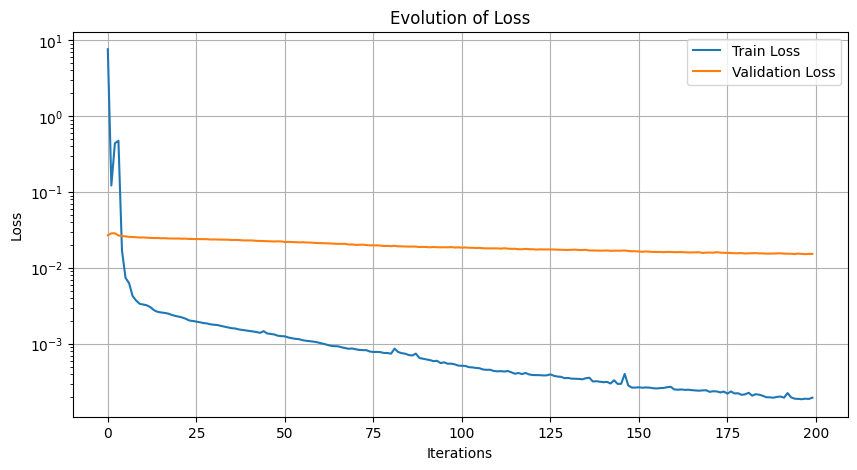

In [14]:
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
plt.plot(train_loss_values, label='Train Loss')
plt.plot(val_loss_values, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Evolution of Loss')
plt.legend()
plt.grid()
plt.show()

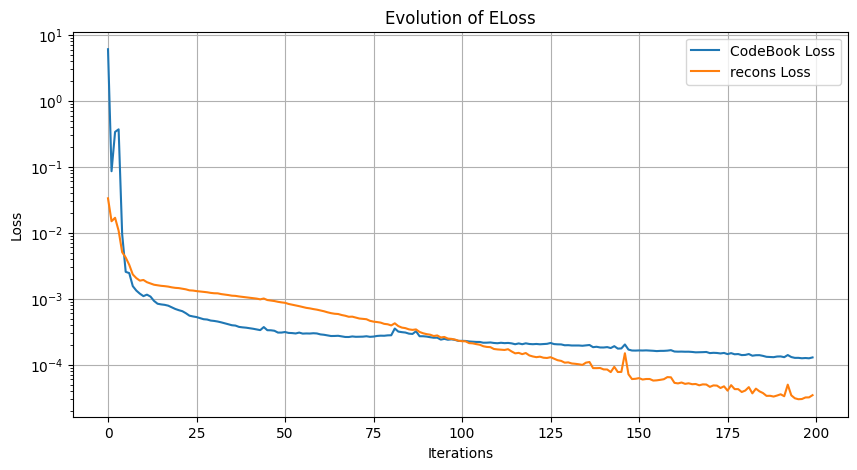

In [17]:
recons_loss_values = np.array(train_loss_values) - ( (1+0.25)*np.array(codebook_loss_values))
# Plot the training and validation losses
plt.figure(figsize=(10, 5))
# plt.plot(train_loss_values, label='Train Loss')
# plt.plot(val_loss_values, label='Validation Loss')
plt.plot(codebook_loss_values, label = "CodeBook Loss")
# plt.plot(commit_loss_values, label = "Committement Loss")
plt.plot(recons_loss_values, label = "recons Loss")
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Evolution of ELoss')
plt.legend()
plt.grid()
plt.show()

# Test ...

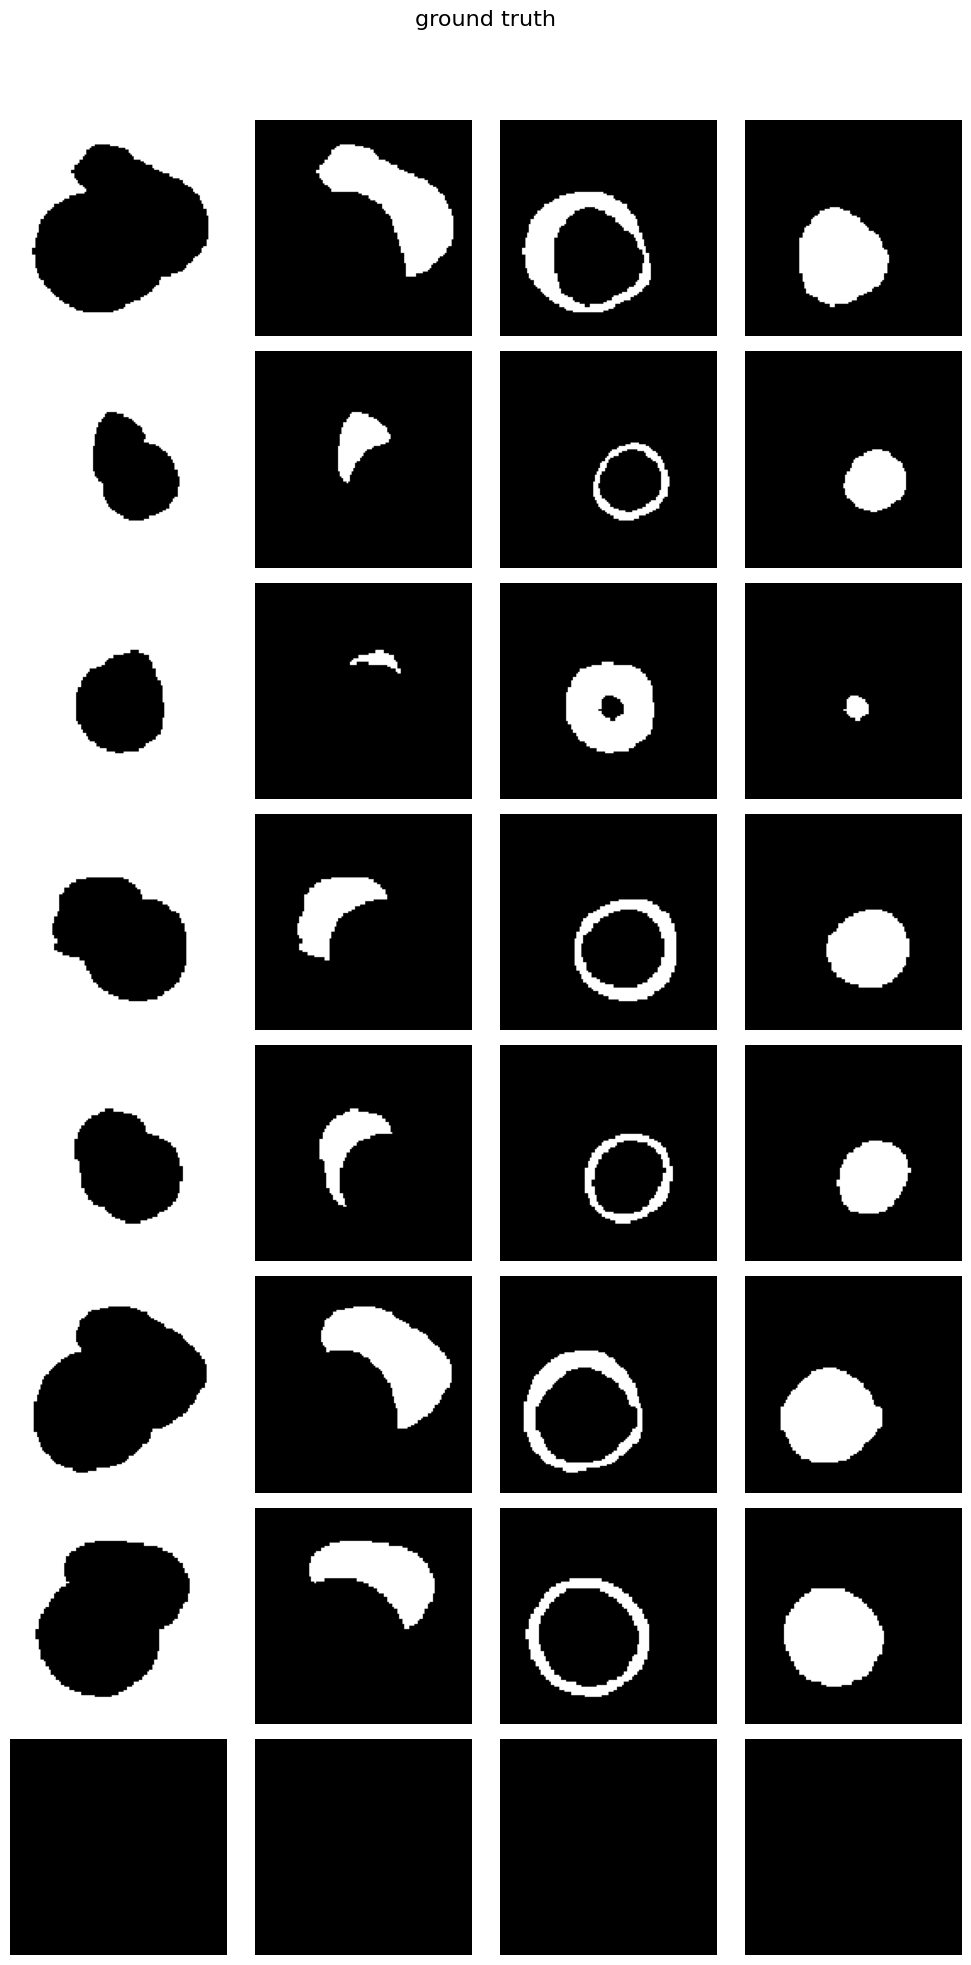

In [18]:
visualize_batch(vis_batch.detach().cpu(), title = "ground truth")

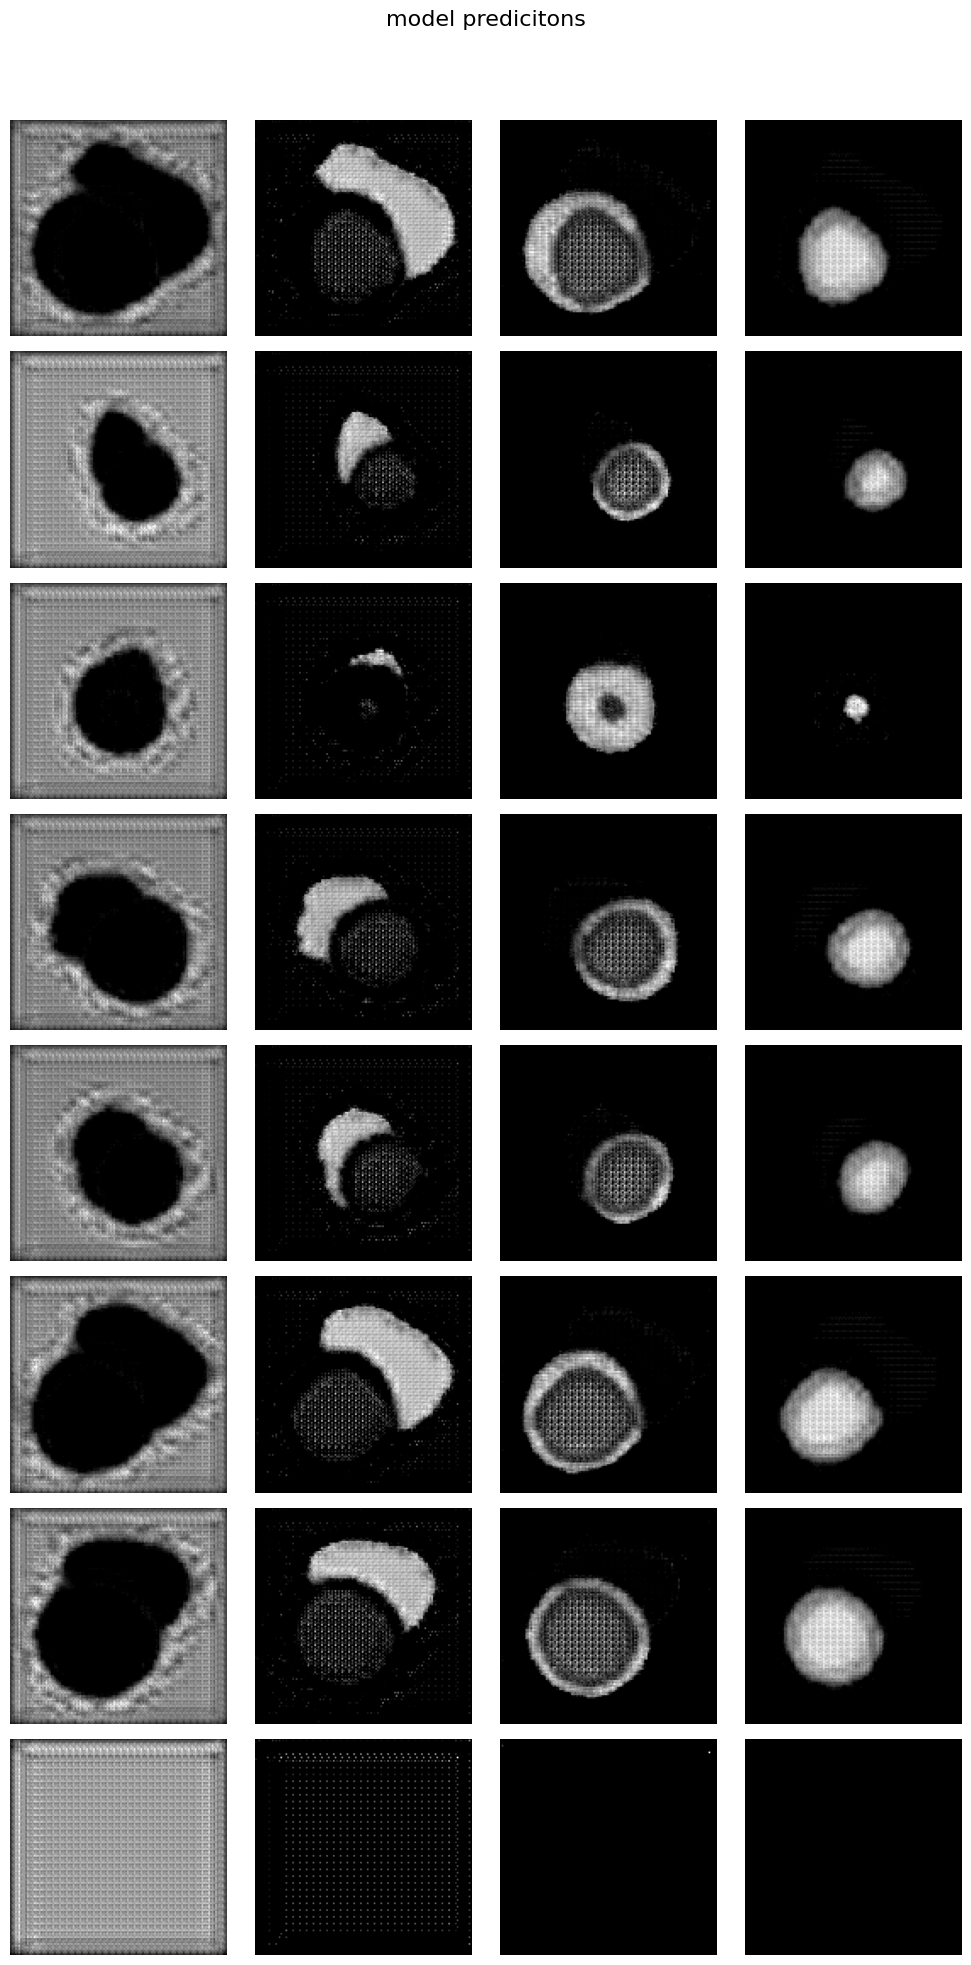

In [19]:
batch_hat = reconstruct(vis_batch, model)

visualize_batch( batch_hat.detach().cpu(), title = "model predicitons")

In [1]:
# visualize_batch(recons_evolution[-1].detach().cpu(), title = "")